##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Addons Losses: WeightedKappaLoss

<table class="tfa-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/addons/api_docs/python/tfa/losses/WeightedKappaLoss"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/addons/blob/master/docs/tutorials/_template.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/addons/blob/v0.11.2/tensorflow_addons/losses/kappa_loss.py#L27-L141"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/addons/docs/tutorials/_template.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook demonstrates how to use the WeightedKappaLoss metric in Tensorflow Addons.


References:
https://www.sciencedirect.com/science/article/abs/pii/S0167865517301666

External resources:
* https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps This article does a great job explaining the Cohen Quadratic Weighted Kappa Loss.
* https://en.wikipedia.org/wiki/Cohen%27s_kappa Wikipedia article on Cohen's Kappa.

### **Kappa Loss**
The kappa loss is used to judge the inter-relatibility between the observations of the predicted and actual value. It's forte lies in the fact that it takes random chance into account and is thus a robust measure. In this notebook, we will focus on **Quadratic Weighted Cohen's Kappa** Loss metric.


As described in the paper, this metric is recommended on multiclass ordinal dataset. The loss metric is given by :


![fig1](https://study.com/cimages/multimages/16/kappa-formula.jpg)


Where Pobserved is the observed proportion of agreement and Pexpected is the probability of agreement by random chance.

## Setup

In [2]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 4.3MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [97]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
import pandas as pd

In [71]:
def prepare_dataset(img, labels, num_classses):
  img = tf.cast(img, tf.float32) / 255.
  img = tf.expand_dims(img, -1)
  labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
  
  return img, labels
  

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Get num classes
num_classes = len(np.unique(y_train))

x_train, y_train = prepare_dataset(x_train, y_train, num_classes)
x_test, y_test = prepare_dataset(x_test, y_test, num_classes)

In [74]:
# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(input_shape = (28, 28, 1), filters = 32, kernel_size = 2, activation = 'relu'),
  tf.keras.layers.MaxPool2D(pool_size = 2),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size = 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])

Compile the model for training:

In [79]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tfa.losses.WeightedKappaLoss(num_classes = num_classes),
              metrics = [tf.keras.metrics.CategoricalAccuracy(), 
                         tfa.metrics.CohenKappa(num_classes = num_classes)]
)

In [81]:
hist = model.fit(x_train, y_train, 
          validation_data = (x_test, y_test),
          batch_size = 32,
          shuffle = True,
          epochs = 5)

Epoch 1/5
1875/1875 [==============================] - 41s 21ms/step - loss: -0.0080 - categorical_accuracy: 0.1906 - cohen_kappa: 0.0949 - val_loss: -0.0114 - val_categorical_accuracy: 0.2412 - val_cohen_kappa: 0.1530
Epoch 2/5
1875/1875 [==============================] - 39s 21ms/step - loss: -0.0201 - categorical_accuracy: 0.2140 - cohen_kappa: 0.1213 - val_loss: -0.0223 - val_categorical_accuracy: 0.2552 - val_cohen_kappa: 0.1692
Epoch 3/5
1875/1875 [==============================] - 39s 21ms/step - loss: -0.0345 - categorical_accuracy: 0.2345 - cohen_kappa: 0.1443 - val_loss: -0.0350 - val_categorical_accuracy: 0.2645 - val_cohen_kappa: 0.1797
Epoch 4/5
1875/1875 [==============================] - 39s 21ms/step - loss: -0.0503 - categorical_accuracy: 0.2411 - cohen_kappa: 0.1521 - val_loss: -0.0500 - val_categorical_accuracy: 0.2583 - val_cohen_kappa: 0.1728
Epoch 5/5
1875/1875 [==============================] - 40s 21ms/step - loss: -0.0685 - categorical_accuracy: 0.2419 - cohen_

### Evaluate

In [ ]:
y_pred = model.predict(x_test)

In [121]:
def plot_confusionmat(y_pred, y_true, num_classes):

  y_pred = tf.argmax(y_pred, axis = 1)
  y_true = tf.argmax(y_test, axis = 1)

  confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes)
  df = pd.DataFrame(confusion_matrix.numpy())
  plt.figure(figsize=(15, 10))
  sns.set(font_scale=1.4)
  ax = sns.heatmap(df, annot=True, annot_kws={"size": 16}, cmap="YlGnBu", fmt='g')
  ax.set(title = "Confusion Matrix",
         xlabel = "Predicted",
         ylabel = "True")
  plt.show()

  return confusion_matrix
  


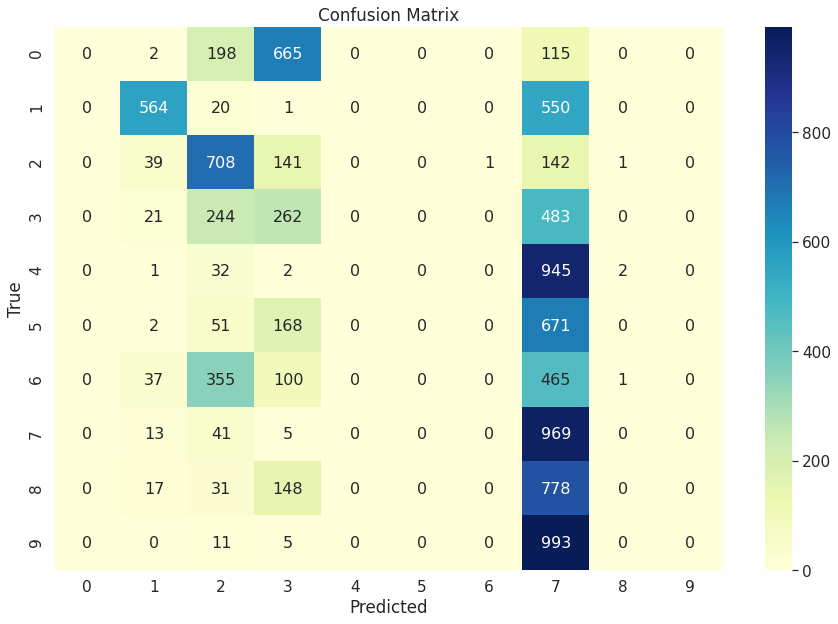

In [122]:
x = plot_confusionmat(y_pred, y_test, num_classes)